In [1]:
from torch import nn
from torch.nn import functional as F
import torch 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
from functional import sparse_relu
from torch.nn.functional import relu as original_relu

In [51]:
dtype = torch.float
device = torch.device("cpu")

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)


In [64]:
# Create random Tensors for weights.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(5000):
    # To apply our Function, we use Function.apply method. We alias this as 'relu'.
    relu = sparse_relu.apply
    # relu = original_relu

    # Forward pass: compute predicted y using operations; we compute
    # ReLU using our custom autograd operation.
    y_pred = relu(x.mm(w1), torch.tensor(0.05), torch.tensor(1e-3)).mm(w2)
    # y_pred = relu(x.mm(w1)).mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

99 591.7969360351562
199 4.046454906463623
299 0.044572532176971436
399 0.0010392953408882022
499 0.0005109953926876187
599 0.0005123534356243908
699 0.0005086007877252996
799 0.0005088309408165514
899 0.000512811413500458
999 0.0005103123257867992
1099 0.0005138643318787217
1199 0.0005146075855009258
1299 0.0005172404344193637
1399 0.0005144352908246219
1499 0.0005151216755621135
1599 0.0005138475680723786
1699 0.0005151548539288342
1799 0.0005157133564352989
1899 0.0005128012271597981
1999 0.0005169901996850967
2099 0.0005134193343110383
2199 0.0005141364526934922
2299 0.0005133046652190387
2399 0.0005134451785124838
2499 0.0005136284744367003
2599 0.0005109379417262971
2699 0.0005130337085574865
2799 0.0005114899831824005
2899 0.0005113482475280762
2999 0.0005125513998791575
3099 0.0005152886151336133
3199 0.0005115101812407374
3299 0.0005109098856337368
3399 0.0005128830671310425
3499 0.0005099016125313938
3599 0.000511359772644937
3699 0.0005086479941383004
3799 0.0005127431359142

In [65]:
lz = (x.mm(w1)<=0).sum()
bz = (x.mm(w1)>0).sum()
print('Number of values closes to 0: {}; bigger: {}'.format(lz, bz))

Number of values closes to 0: 3451; bigger: 2949


In [49]:
loss

tensor(0.0422, grad_fn=<SumBackward0>)

In [66]:
a = x.mm(w1).cpu()

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  2.,  5.,  6.,  9.,  5.,
         4., 16.,  7.,  9.,  8.,  4.,  6.,  7.,  5.,  0.,  1.,  1.]),
 array([-110.60116  , -103.14107  ,  -95.68098  ,  -88.22089  ,
         -80.760796 ,  -73.3007   ,  -65.84061  ,  -58.380516 ,
         -50.920425 ,  -43.460335 ,  -36.000244 ,  -28.540152 ,
         -21.08006  ,  -13.619968 ,   -6.1598763,    1.3002151,
           8.760306 ,   16.220398 ,   23.68049  ,   31.140581 ,
          38.600674 ,   46.060764 ,   53.520855 ,   60.98095  ,
          68.44104  ,   75.90113  ], dtype=float32),
 <BarContainer object of 25 artists>)

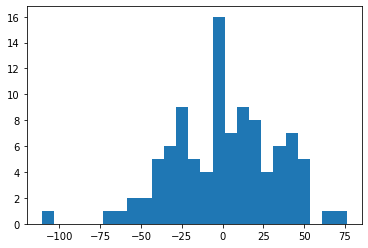

In [67]:
from matplotlib import pyplot as plt
plt.hist(a[0].detach().cpu().numpy(), bins=25)
